In [1]:
# load in all the modules we're going to need
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pprint import pprint
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis
import pyLDAvis.gensim
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)
import json
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist

Bad val 'GTKAgg' on line #32
	"backend      : GTKAgg
"
	in file "/home/alex/.local/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"
	Key backend: Unrecognized backend string 'gtkagg': valid strings are ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
/home/alex/anaconda3/envs/deepLearning/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/home/alex/anaconda3/envs/deepLearning/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict


Load Data

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_csv("../cleaned_again_2.csv")#,keep_default_na=False)
#print(df.shape)
df = df[~df['reviewText'].str.contains("\.jpg|\.png|\.jpeg|\.tiff|\.gif|\.bmp|\.heif", regex=True, na=False)]
df = df.dropna()
#print(df.shape)
# pprint(df.reviewText[9])
# df.reviewText[9].find("the")
# df.reviewText[9][245:260]
#df.to_csv('kindle_reviews_removed.csv', index=False)
df_2 = pd.read_csv("../preprocess/new_clean.csv")


<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<ipython-input-2-a6d5bf4954f7>:4: DeprecationWarning: invalid escape sequence \.
  df = df[~df['reviewText'].str.contains("\.jpg|\.png|\.jpeg|\.tiff|\.gif|\.bmp|\.heif", regex=True, na=False)]


Count review Lengths

In [4]:
df['reviewLength'] = df.reviewText.str.lower().str.split().apply(len)
lengths = df.reviewLength.value_counts()
pprint(df.iloc[df.reviewLength.argmax()].reviewText)
print(f"Max text length is {df.reviewLength.max()}")

('true love kiss ben cassidysir giles lily ella elf witch human dirk shadow '
 'thief torval barbarian fighting beast kiss girl deep sleep kiss true love '
 'awoke moment j.l. jarviscam mac sisters cam married kids setting mac men '
 'marry life wants wants scotsman highlander type man gets imagined man named '
 'ciaran macrae meets eye time runs vanishes come truly kiss kick ass kiss '
 'shirley bourgetwow makes think future like self destroy ways knew think '
 'change past interesting quick read makes think today april kiss anthology '
 'love close encountersapril father kiss slammed series epilogue colleen '
 'hoovermrs katie foster parent olivia king soon mrs. katie care anymore '
 'moving live daughter later olivia changes eddie change uncertain family '
 'daughter names katie foster mother layken daughter named layken family julia '
 'gavin eddie olivia husband kel cauldor friends act like brothers protect '
 'katie julia kel kiersten going having issues eddie sees talk cauldor l

In [4]:
# index = df.reviewLength.argmax()
# pprint(df.iloc[index].reviewText)

The distribution of review word count

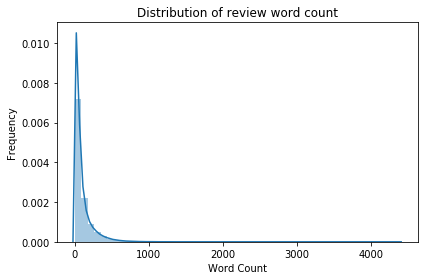

In [5]:
#remove_outliers = df[np.abs(df.reviewLength-df.reviewLength.mean())<=(3*df.reviewLength.std())] 
#keep only the ones that are within +3 to -3 standard deviations in the column 'reviewLength'

#ax = sns.distplot(remove_outliers.reviewLength)
ax = sns.distplot(df.reviewLength)
ax.set(ylabel='Frequency', title="Distribution of review word count", xlabel="Word Count")
# Mention the removal of outliers due to long review lengths
ax.get_figure().tight_layout()
ax.get_figure().savefig("distribution_of_word_count.png")



Review Length - number of letters

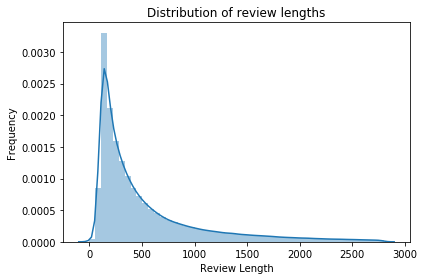

In [6]:
df['letterCount'] = df.reviewText.str.lower().apply(len)
remove_outliers_2 = df[np.abs(df.letterCount-df.letterCount.mean())<=(3*df.letterCount.std())] 

ax = sns.distplot(remove_outliers_2.letterCount)
ax.set(ylabel='Frequency', title="Distribution of review lengths", xlabel="Review Length")
# Mention the removal of outliers due to long review lengths
ax.get_figure().tight_layout()
ax.get_figure().savefig("distribution_of_review_lengths_letters.png")




Number of word per rating distriubtion


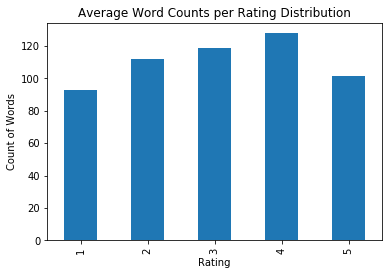

In [6]:
word_avg = df.groupby('overall')['reviewLength'].mean().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("Count of Words")
plt.title("Average Word Counts per Rating Distribution")
plt.savefig("Average_Number_of_Words_per_Rating_Distribution.png")


Pie Chart

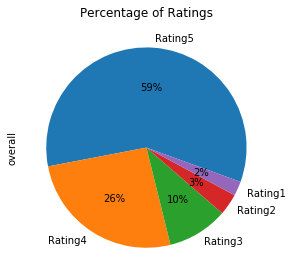

In [22]:
plt.figure()
plt.title("Percentage of Ratings")
df.overall.value_counts().plot(kind='pie', 
                              labels = ['Rating5','Rating4','Rating3','Rating2','Rating1'],
                               autopct='%1.0f%%',
                               startangle= -20)

plt.tight_layout()
plt.savefig("ratings_pie.png", dpi=100, bbox='inches')    

# N-Grams after cleaning

In [5]:

rating1 = df['overall']==1
rating2 = df['overall']==2
rating3 = df['overall']==3
rating4 = df['overall']==4
rating5 = df['overall']==5

In [6]:
def generate_ngrams(text, n_gram=1):
    token = text.split()
    if "this" in token:
        print()
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [7]:
from collections import defaultdict

rating1_unigrams = defaultdict(int)
rating2_unigrams = defaultdict(int)
rating3_unigrams = defaultdict(int)
rating4_unigrams = defaultdict(int)
rating5_unigrams = defaultdict(int)

Uni-gram

In [11]:
for inx, review in enumerate(df[rating1]['reviewText']):
    for word in generate_ngrams(review):
        rating1_unigrams[word] += 1

for inx, review in enumerate(df[rating2]['reviewText']):
    for word in generate_ngrams(review):
        rating2_unigrams[word] += 1

for inx, review in enumerate(df[rating3]['reviewText']):
    for word in generate_ngrams(review):
        rating3_unigrams[word] += 1

for inx, review in enumerate(df[rating4]['reviewText']):
    for word in generate_ngrams(review):
        rating4_unigrams[word] += 1
        
for inx, review in enumerate(df[rating5]['reviewText']):
    for word in generate_ngrams(review):
        rating5_unigrams[word] += 1

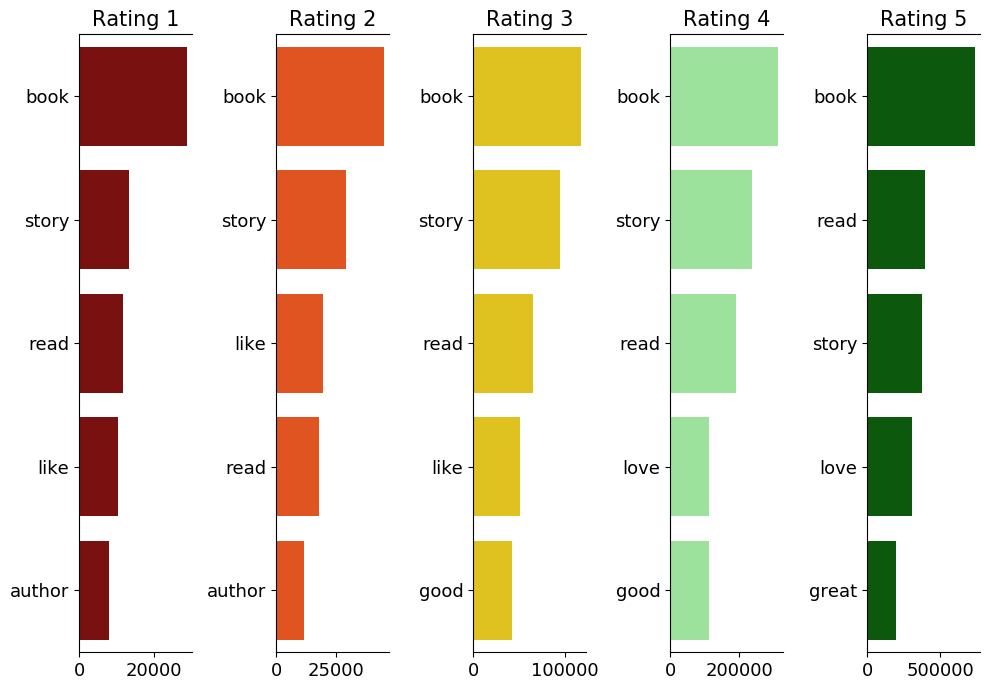

In [20]:
df_rating1_unigrams = pd.DataFrame(sorted(rating1_unigrams.items(), key=lambda x: x[1])[::-1])
df_rating2_unigrams = pd.DataFrame(sorted(rating2_unigrams.items(), key=lambda x: x[1])[::-1])
df_rating3_unigrams = pd.DataFrame(sorted(rating3_unigrams.items(), key=lambda x: x[1])[::-1])
df_rating4_unigrams = pd.DataFrame(sorted(rating4_unigrams.items(), key=lambda x: x[1])[::-1])
df_rating5_unigrams = pd.DataFrame(sorted(rating5_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=5, figsize=(10, 7), dpi=100)


N = 5 #only select top n unigrams

sns.barplot(y=df_rating1_unigrams[0].values[:N], x=df_rating1_unigrams[1].values[:N], ax=axes[0], color='darkred')
sns.barplot(y=df_rating2_unigrams[0].values[:N], x=df_rating2_unigrams[1].values[:N], ax=axes[1], color='orangered')
sns.barplot(y=df_rating3_unigrams[0].values[:N], x=df_rating3_unigrams[1].values[:N], ax=axes[2], color='gold')
sns.barplot(y=df_rating4_unigrams[0].values[:N], x=df_rating4_unigrams[1].values[:N], ax=axes[3], color='lightgreen')
sns.barplot(y=df_rating5_unigrams[0].values[:N], x=df_rating5_unigrams[1].values[:N], ax=axes[4], color='darkgreen')

for i in range(5):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Rating 1', fontsize=15)
axes[1].set_title(f'Rating 2', fontsize=15)
axes[2].set_title(f'Rating 3', fontsize=15)
axes[3].set_title(f'Rating 4', fontsize=15)
axes[4].set_title(f'Rating 5', fontsize=15)

plt.tight_layout()
plt.savefig("unigram_clean.png")

Bi-gram

In [13]:
rating1_bigrams = defaultdict(int)
rating2_bigrams = defaultdict(int)
rating3_bigrams = defaultdict(int)
rating4_bigrams = defaultdict(int)
rating5_bigrams = defaultdict(int)

In [14]:
for review in df[rating1]['reviewText']:
    for word in generate_ngrams(review, n_gram = 2):
        rating1_bigrams[word] += 1

for review in df[rating2]['reviewText']:
    for word in generate_ngrams(review, n_gram = 2):
        rating2_bigrams[word] += 1

for review in df[rating3]['reviewText']:
    for word in generate_ngrams(review, n_gram = 2):
        rating3_bigrams[word] += 1

for review in df[rating4]['reviewText']:
    for word in generate_ngrams(review, n_gram = 2):
        rating4_bigrams[word] += 1

for review in df[rating5]['reviewText']:
    for word in generate_ngrams(review, n_gram = 2):
        rating5_bigrams[word] += 1

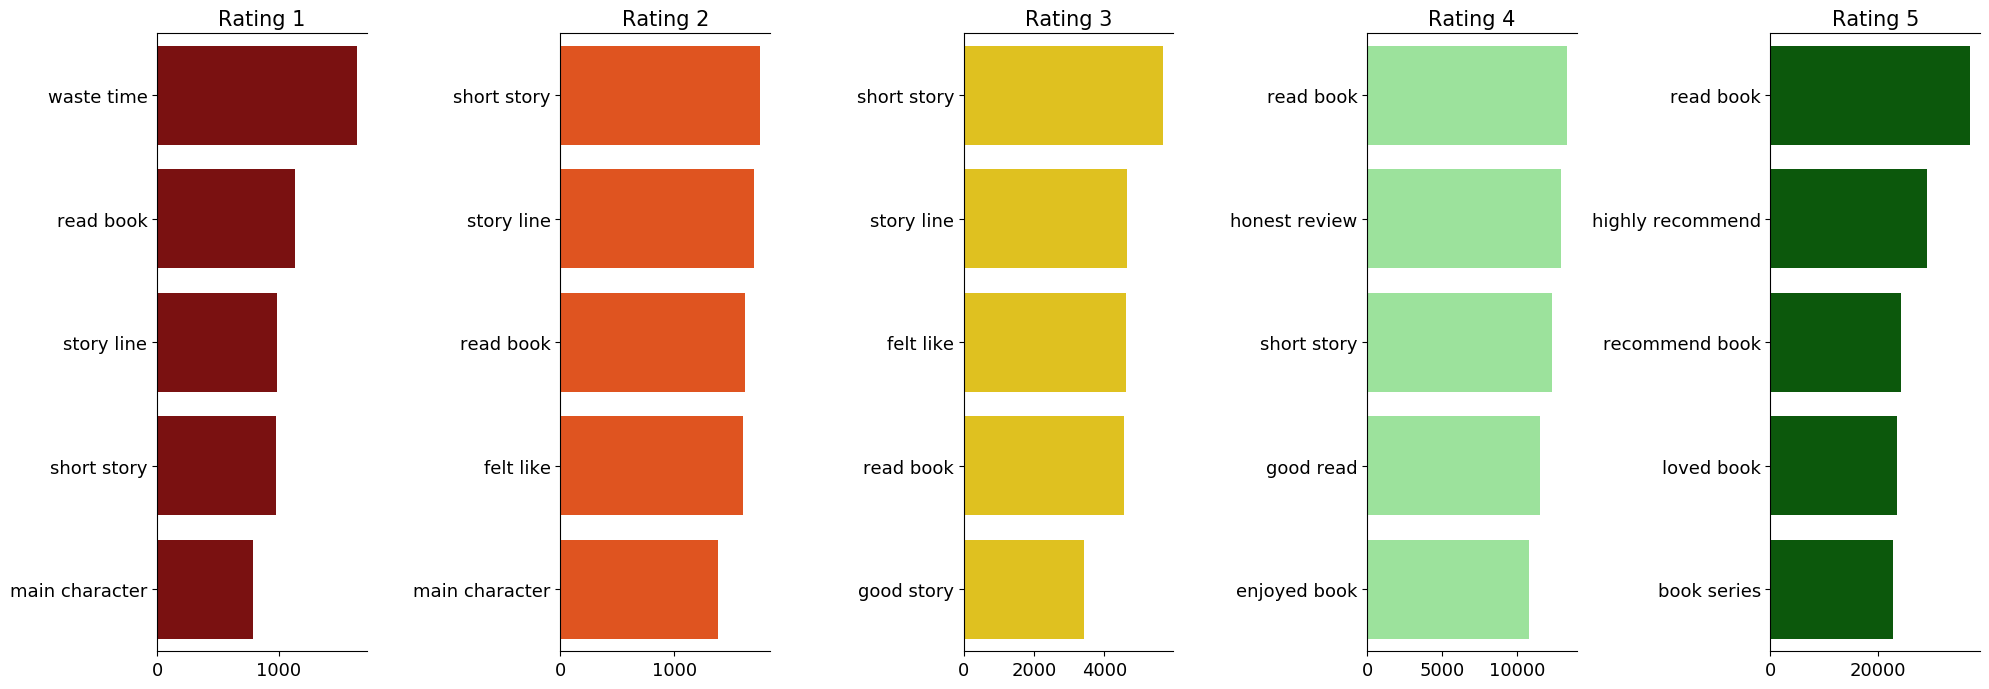

In [21]:
df_rating1_bigrams = pd.DataFrame(sorted(rating1_bigrams.items(), key=lambda x: x[1])[::-1])
df_rating2_bigrams = pd.DataFrame(sorted(rating2_bigrams.items(), key=lambda x: x[1])[::-1])
df_rating3_bigrams = pd.DataFrame(sorted(rating3_bigrams.items(), key=lambda x: x[1])[::-1])
df_rating4_bigrams = pd.DataFrame(sorted(rating4_bigrams.items(), key=lambda x: x[1])[::-1])
df_rating5_bigrams = pd.DataFrame(sorted(rating5_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=5, figsize=(20, 7), dpi=100)
plt.tight_layout()

N = 5 #only select top n unigrams

sns.barplot(y=df_rating1_bigrams[0].values[:N], x=df_rating1_bigrams[1].values[:N], ax=axes[0], color='darkred')
sns.barplot(y=df_rating2_bigrams[0].values[:N], x=df_rating2_bigrams[1].values[:N], ax=axes[1], color='orangered')
sns.barplot(y=df_rating3_bigrams[0].values[:N], x=df_rating3_bigrams[1].values[:N], ax=axes[2], color='gold')
sns.barplot(y=df_rating4_bigrams[0].values[:N], x=df_rating4_bigrams[1].values[:N], ax=axes[3], color='lightgreen')
sns.barplot(y=df_rating5_bigrams[0].values[:N], x=df_rating5_bigrams[1].values[:N], ax=axes[4], color='darkgreen')

for i in range(5):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Rating 1', fontsize=15)
axes[1].set_title(f'Rating 2', fontsize=15)
axes[2].set_title(f'Rating 3', fontsize=15)
axes[3].set_title(f'Rating 4', fontsize=15)
axes[4].set_title(f'Rating 5', fontsize=15)

plt.tight_layout()
plt.savefig("bigram_clean.png")

In [9]:
rating1_trigrams = defaultdict(int)
rating2_trigrams = defaultdict(int)
rating3_trigrams = defaultdict(int)
rating4_trigrams = defaultdict(int)
rating5_trigrams = defaultdict(int)

In [10]:
for review in df[rating1]['reviewText']:
    for inx, word in enumerate(generate_ngrams(review, n_gram = 3)):
        rating1_trigrams[word] += 1

for review in df[rating2]['reviewText']:
    for word in generate_ngrams(review, n_gram = 3):
        rating2_trigrams[word] += 1

for review in df[rating3]['reviewText']:
    for word in generate_ngrams(review, n_gram = 3):
        rating3_trigrams[word] += 1

for review in df[rating4]['reviewText']:
    for word in generate_ngrams(review, n_gram = 3):
        rating4_trigrams[word] += 1

for review in df[rating5]['reviewText']:
    for word in generate_ngrams(review, n_gram = 3):
        rating5_trigrams[word] += 1

Rating 1: 
['wast time money' 'wast time read' 'worst book read' 'book wast time'
 'read book author'] [291 189 147 143 135]
Rating 2: 
['exchang honest review' 'want like book' 'read book seri'
 'read book author' 'look forward read'] [294 292 231 165 159]
Rating 3: 
['exchang honest review' 'look forward read' 'read book seri'
 'book exchang honest' 'copi book exchang'] [2093  974  929  644  576]
Rating 4: 
['exchang honest review' 'look forward read' 'read book seri'
 'look forward book' 'book exchang honest'] [7668 6302 2835 2641 2339]
Rating 5: 
['look forward read' 'highli recommend book' 'exchang honest review'
 'read book seri' 'look forward book'] [11374  9785  7502  5681  5181]


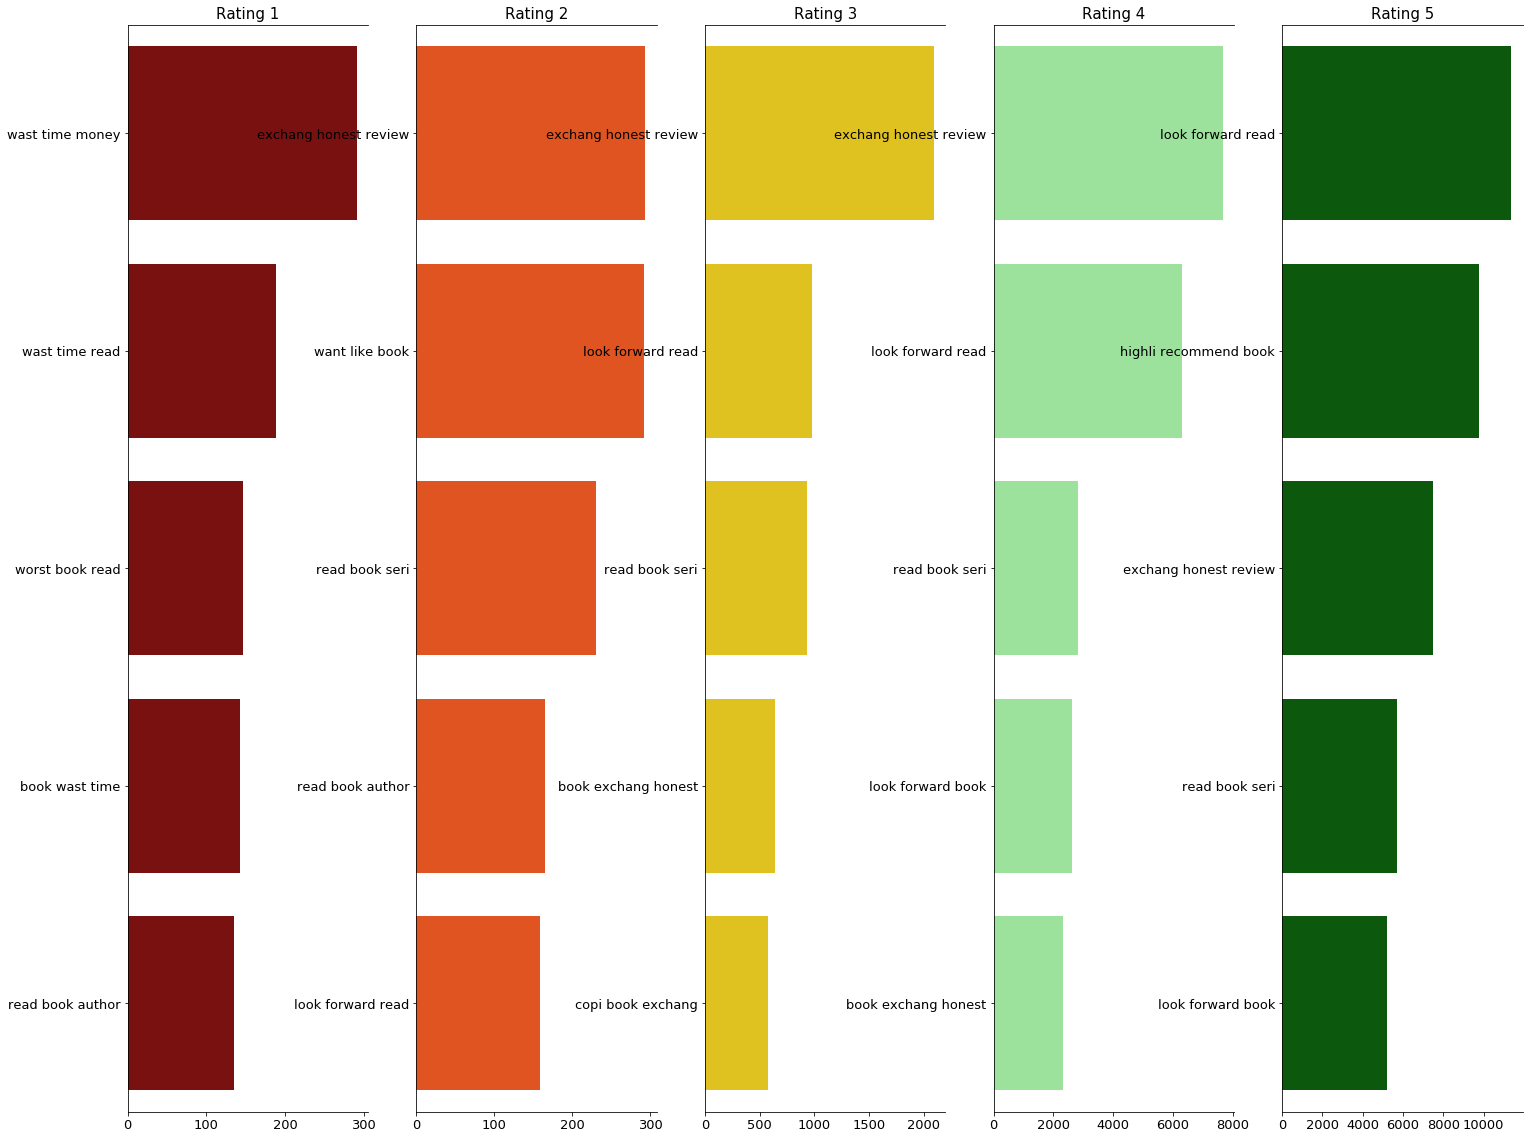

In [11]:
df_rating1_trigrams = pd.DataFrame(sorted(rating1_trigrams.items(), key=lambda x: x[1])[::-1])
df_rating2_trigrams = pd.DataFrame(sorted(rating2_trigrams.items(), key=lambda x: x[1])[::-1])
df_rating3_trigrams = pd.DataFrame(sorted(rating3_trigrams.items(), key=lambda x: x[1])[::-1])
df_rating4_trigrams = pd.DataFrame(sorted(rating4_trigrams.items(), key=lambda x: x[1])[::-1])
df_rating5_trigrams = pd.DataFrame(sorted(rating5_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=5, figsize=(25, 20))

N = 5 #only select top n unigrams

print("Rating 1: ")
print(df_rating1_trigrams[0].values[:N], df_rating1_trigrams[1].values[:N])
print("Rating 2: ")
print(df_rating2_trigrams[0].values[:N], df_rating2_trigrams[1].values[:N])
print("Rating 3: ")
print(df_rating3_trigrams[0].values[:N], df_rating3_trigrams[1].values[:N])
print("Rating 4: ")
print(df_rating4_trigrams[0].values[:N], df_rating4_trigrams[1].values[:N])
print("Rating 5: ")
print(df_rating5_trigrams[0].values[:N], df_rating5_trigrams[1].values[:N])

sns.barplot(y=df_rating1_trigrams[0].values[:N], x=df_rating1_trigrams[1].values[:N], ax=axes[0], color='darkred')
sns.barplot(y=df_rating2_trigrams[0].values[:N], x=df_rating2_trigrams[1].values[:N], ax=axes[1], color='orangered')
sns.barplot(y=df_rating3_trigrams[0].values[:N], x=df_rating3_trigrams[1].values[:N], ax=axes[2], color='gold')
sns.barplot(y=df_rating4_trigrams[0].values[:N], x=df_rating4_trigrams[1].values[:N], ax=axes[3], color='lightgreen')
sns.barplot(y=df_rating5_trigrams[0].values[:N], x=df_rating5_trigrams[1].values[:N], ax=axes[4], color='darkgreen')

for i in range(5):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Rating 1', fontsize=15)
axes[1].set_title(f'Rating 2', fontsize=15)
axes[2].set_title(f'Rating 3', fontsize=15)
axes[3].set_title(f'Rating 4', fontsize=15)
axes[4].set_title(f'Rating 5', fontsize=15)

plt.savefig("trigram_cleaned.png")


Embeddings percentage

See Google Collab

Topic Modelling

In [4]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=1000)
tf = tf_vectorizer.fit_transform(df['reviewText'].values)
tf_feature_names = tf_vectorizer.get_feature_names()


Genism

In [9]:
df = df['reviewText'].apply(lambda x: x.split())

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(df)

# Create Corpus
texts = df

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [5]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           eval_every=10,
                                           workers = 3)

In [16]:
lda_model.save('topic.model')

In [3]:

lda_model = LdaModel.load('topic.model')

In [8]:

topics = lda_model.show_topics(num_topics=10, num_words=10, log=False, formatted=False)
for topic_idx, topic in topics:
    print(f"Topic {topic_idx}:")
    #print(topic)
    print(" ".join([x[0] for x in topic]))
    

Topic 0:
family life man father story home years town new find
Topic 1:
book great recipes good easy read information author diet help
Topic 2:
story world author characters novel read stories life reader people
Topic 3:
story hot book sex like read good love characters little
Topic 4:
book like read little story children fun kids time old
Topic 5:
love book life story loved know way like heart want
Topic 6:
love story romance characters heart series olivia ms. emma wonderful
Topic 7:
book story read characters author good like reading end books
Topic 8:
book read series love great books story wait loved reading
Topic 9:
series jack new find mate book review alpha world pack


In [11]:
#pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
#pyLDAvis.show(vis)

In [13]:
pyLDAvis.save_html(vis, 'LDA.html')
pyLDAvis.save_json(vis, 'LDA.json')

In [15]:
pyLDAvis.display(vis)



Display LDA in matplotlin

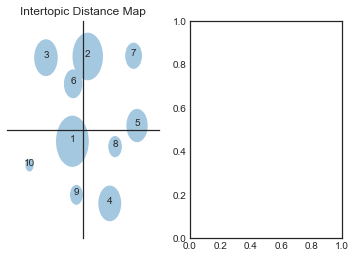

In [8]:
plt.style.use("seaborn-white")
fig, ax = plt.subplots(nrows=1, ncols=2)
with open('LDA.json') as json_file:
    data = json.load(json_file)['mdsDat']
    x = np.asarray(data['x'])
    y = np.asarray(data['y'])
    topics = np.asarray(data['topics'])
    freq = np.asarray(data['Freq'])
    max_size = 0.45
    total_freq = sum(freq)
    sizes = []
    for size in freq:
        sizes.append((size/total_freq) * max_size)
        
    
    #fig = plt.figure(figsize=(20,20))
    #ax[0] = fig.add_subplot(1, 1, 1)
   
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax[0].spines['left'].set_position('center')
    ax[0].spines['bottom'].set_position('center')

    # Eliminate upper and right axes
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    
    ax[0].set_xlim(x.min() - 0.1,x.max()+0.1)
    ax[0].set_ylim(y.min() - 0.1,y.max()+0.1)
    
    ax[0].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    ax[0].set_yticks([])    
    for x_pos, y_pos, r, top in zip(x,y, sizes,topics):
        temp = plt.Circle((x_pos,y_pos),r, facecolor='#A5C8E1')
        ax[0].add_artist(temp)
        ax[0].annotate(f"{top}", xy=(x_pos, y_pos), ha="center")

    ax[0].set_title("Intertopic Distance Map")    #fig.tight_layout()
    #fig.savefig("LDA.png")

In [10]:

with open('LDA.json') as json_file:
    data = json.load(json_file)['tinfo']
    terms = np.asarray(data['Term'])
    freq = np.asarray(data['Freq'])
    ax[1].barh(terms[:10], freq[:10], color='#A5C8E1')
    ax[1].set_title("Top-10 Most Salient Terms")
    ax[1].set_xlabel("Frequency")
    ax[1].invert_yaxis()

#ax[1].invert_yaxis()
fig.tight_layout()
fig.savefig("LDA.png", bbox_inches="tight", dpi=100,transparent=True)

NMF

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,min_df =2, max_features=1000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['reviewText'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components=10, random_state=0, alpha=.1).fit(tfidf)

In [4]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join(feature_names[i]
                       for i in topic.argsort()[:-no_top_words -1 :-1]))

In [6]:
display_topics(nmf, tfidf_feature_names, 10)



Topic 0:
book recommend reading enjoyed author highly written information looking second
Topic 1:
story short characters enjoyed line written stories author interesting liked
Topic 2:
series wait characters rest installment new hope better forward start
Topic 3:
good like pretty bad ending little job plot liked work
Topic 4:
great job recipes easy highly work tips thanks lots characters
Topic 5:
love fall hot heart amazing romance fell sweet true family
Topic 6:
read fun quick wait easy enjoyable want worth definitely fast
Topic 7:
like life time way know things find little going think
Topic 8:
books reading author enjoyed forward like look looking enjoy stories
Topic 9:
loved wait hot absolutely characters amazing awesome sexy end ending


In [ ]:
Word Fequency

In [ ]:
words = df['reviewText']
allwords = []
for wordlist in words:
    allwords += wordlist
    

In [ ]:

mostcommon = FreqDist(allwords).most_common(10)


In [19]:
x = df.helpful.apply(lambda x: x.replace(",","").lstrip('[').rstrip(']').split())
y = x.apply(lambda t : int(t[0])/int(t[1]) if (int(t[0]) != 0) else 0)
df['helpfulRatio'] = y
df = df.loc[df['helpfulRatio'] != 0]



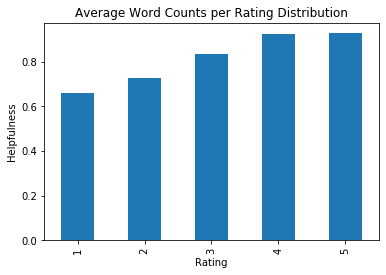

In [20]:
helpful_avg = df.groupby('overall')['helpfulRatio'].mean().plot(kind='bar')
plt.xlabel("Rating")
plt.ylabel("Helpfulness")
plt.title("Average Word Counts per Rating Distribution")
plt.savefig("Average_Number_of_Words_per_Rating_Distribution.png")